In [1]:
import numpy as np
from tqdm import tqdm

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
class Minesweeper:

    DEFAULT = -98  # Empty tiles. (Haven't been chosen yet)
    BOMB = -100  # Bombs that are not yet labeled.
    LABELBOMB = -99  # Bombs the user has labeled.

    def __init__(self, length: int, width: int, bombs: int, custom_board=None):
        self.length = length
        self.width = width
        self.bombs = bombs
        self.moves = 0

        # Create a new board if a custom board is not given.
        if custom_board is None:
            self.board = np.zeros((self.length, self.width)) + Minesweeper.DEFAULT
        else:
            self.board = custom_board

        self.game_running = True


    def valid(self, x: int, y: int):
        return 0 <= x < self.length and 0 <= y < self.width

    def adj(self, x: int, y: int):
        return self.board[max(0, x-1):min(self.length, x+2),
                          max(0, y-1):min(self.width, y+2)]

    def reveal(self, x: int, y: int):
        def _reveal(xi, yi):
            if (not self.valid(xi, yi)
                or self.board[xi, yi] >= 0
                    or self.board[xi, yi] in [Minesweeper.BOMB, Minesweeper.LABELBOMB]):
                return
            # Set the total to the sum of the bombs and the labeled bombs.
            self.board[xi, yi] = (np.sum(self.adj(xi, yi) == Minesweeper.BOMB) +
                                  np.sum(self.adj(xi, yi) == Minesweeper.LABELBOMB))
            # Reveal the neighbors.
            if self.board[xi, yi] == 0:
                _reveal(xi - 1, yi - 1)
                _reveal(xi + 1, yi + 1)
                _reveal(xi + 1, yi - 1)
                _reveal(xi - 1, yi + 1)
                _reveal(xi, yi - 1)
                _reveal(xi, yi + 1)
                _reveal(xi - 1, yi)
                _reveal(xi + 1, yi)

        if not self.valid(x, y) or self.board[x, y] >= 0 or not self.game_running:
            return
        
        self.moves += 1
        
        if self.board[x, y] == Minesweeper.BOMB or self.board[x, y] == Minesweeper.LABELBOMB:
            self.game_running = False
            return
        
        if self.moves == 1:
            probs = np.ones_like(self.board)
            probs[max(0, x-1):min(self.length, x+2),max(0, y-1):min(self.width, y+2)] = 0
            probs[:, :] = 1 / np.count_nonzero(probs)
            probs[max(0, x-1):min(self.length, x+2),max(0, y-1):min(self.width, y+2)] = 0
            probs = probs.flatten()
            
            shape = self.board.shape
            temp = self.board.flatten()
            temp[np.random.choice(temp.shape[0], self.bombs,
                                  replace=False, p=probs)] = Minesweeper.BOMB
            temp = temp.reshape(shape)
            self.board = temp

        _reveal(x, y)
        if self.game_won():
            self.game_running = False

    def mark(self, x: int, y: int):
        if not self.valid(x, y):
            return True
        if self.board[x, y] != Minesweeper.BOMB:
            return False  # Wrong Move! A non bomb tile has been covered.
        self.board[x, y] = Minesweeper.LABELBOMB
        return True

    def user_view(self):
        board = np.copy(self.board)
        board[board == Minesweeper.BOMB] = Minesweeper.DEFAULT
        return board

    def revealed(self):
        return np.argwhere(self.board >= 0)

    def bombs_remaining(self):
        return np.sum(self.board == Minesweeper.BOMB)

    def game_won(self):
        return self.bombs_remaining() == 0

    def print(self):
        text = ""
        text += ("\n" + ("-" * 4) * self.length + "-") + "\n"
        for rows in self.board:
            text += "| "
            for col in rows:

                if int(col) == Minesweeper.DEFAULT:
                    char_to_print = f"{' ':^1}"
                elif int(col) == Minesweeper.BOMB:
                    char_to_print = f"{'•':^1}"
                elif int(col) == 0:
                    char_to_print = f"{'O':^1}"
                elif int(col) == Minesweeper.LABELBOMB:
                    char_to_print = f"{'⚐':^1}"
                else:
                    char_to_print = f"{int(col):^1}"

                text += f"{char_to_print} | "

            text += "\n" + ("-" * 4) * self.length + "-\n"
        print(text)

    def user_print(self):
        text = ""
        board = self.user_view()
        text += ("\n" + ("-" * 4) * self.length + "-") + "\n"
        for rows in board:
            text += "| "
            for col in rows:

                if int(col) == Minesweeper.DEFAULT:
                    char_to_print = f"{' ':^1}"
                elif int(col) == 0:
                    char_to_print = f"{'O':^1}"
                elif int(col) == Minesweeper.LABELBOMB:
                    char_to_print = f"{'⚐':^1}"
                else:
                    char_to_print = f"{int(col):^1}"

                text += f"{char_to_print} | "

            text += "\n" + ("-" * 4) * self.length + "-\n"
        print(text)

In [3]:
board = Minesweeper(10, 10, 20)
board.print()
board.reveal(3, 3)
board.print()


-----------------------------------------
|   |   |   |   |   |   |   |   |   |   | 
-----------------------------------------
|   |   |   |   |   |   |   |   |   |   | 
-----------------------------------------
|   |   |   |   |   |   |   |   |   |   | 
-----------------------------------------
|   |   |   |   |   |   |   |   |   |   | 
-----------------------------------------
|   |   |   |   |   |   |   |   |   |   | 
-----------------------------------------
|   |   |   |   |   |   |   |   |   |   | 
-----------------------------------------
|   |   |   |   |   |   |   |   |   |   | 
-----------------------------------------
|   |   |   |   |   |   |   |   |   |   | 
-----------------------------------------
|   |   |   |   |   |   |   |   |   |   | 
-----------------------------------------
|   |   |   |   |   |   |   |   |   |   | 
-----------------------------------------


-----------------------------------------
|   |   |   | 1 | O | O | 1 |   | • | • | 
--------------------

In [9]:
def neighbors(board, x, y):
    l, w = board.shape
    return board[max(0, x-1):min(l, x+2), max(0, y-1):min(w, y+2)]


def find_bombs(board):
    l, w = board.shape
    labels = []
    for (x, y) in np.argwhere(board > 0):
        num_bombs = board[x, y] - \
            np.sum(neighbors(board, x, y) == Minesweeper.LABELBOMB)
        num_squares = np.sum(neighbors(board, x, y) == Minesweeper.DEFAULT)
        if num_bombs == num_squares:
            indicies = [[x-1, y-1], [x-1, y], [x-1, y+1], [x, y-1],
                        [x, y+1], [x+1, y-1], [x+1, y], [x+1, y+1]]
            for (xi, yi) in indicies:
                if (0 <= xi < l and 0 <= yi < w
                        and board[xi, yi] == Minesweeper.DEFAULT):
                    labels.append((xi, yi))
    labels = set(labels)
    return labels


def mark_bombs(board):
    bomblist = find_bombs(board.user_view())
    for (x, y) in bomblist:
        if not board.mark(x, y):
            board.game_running = False
            print(x, y)
            break
    return bomblist


def calculate_matrix(board, revealed_indices):
    matrix = np.zeros_like(board) + 0.0
    l, w = board.shape

    for (x, y) in revealed_indices:
        num_bombs = board[x, y] - \
            np.sum(neighbors(board, x, y) == Minesweeper.LABELBOMB)
        num_squares = np.sum(neighbors(board, x, y) == Minesweeper.DEFAULT)

        if num_squares == 0:
            # There aren't any squares for the revealed index,
            # don't do anything
            prob = 0.0
        elif num_bombs / num_squares == 0:
            prob = -10  # Choose these squares, they r the safest options.
        else:
            prob = num_bombs / num_squares

        matrix[max(0, x-1):min(l, x+2), max(0, y-1):min(w, y+2)] += prob

    indices = np.argwhere(board >= 0)
    matrix[indices[:, 0], indices[:, 1]] = 0

    indices = np.argwhere(board == Minesweeper.LABELBOMB)
    matrix[indices[:, 0], indices[:, 1]] = 0

    matrix[matrix == 0.0] = 10
    return matrix


def make_guess(board):
    bomblist = mark_bombs(board)
    matrix = calculate_matrix(board.user_view(), board.revealed())
    lowest = np.argwhere(matrix == np.min(matrix))
    np.random.shuffle(lowest)
    guess = lowest[0]
    board.reveal(guess[0], guess[1])
    return guess, lowest, matrix, bomblist

In [10]:
guess, guesses, probmatrix, bombs = make_guess(board)
num_moves += 1

if board.game_running and num_moves > 1:
    print(guess, probmatrix[guess[0], guess[1]])
    board.reveal(guess[0], guess[1])
    board.print()

print(f"Game Running: {board.game_running}")
print(f"Game Won: {board.game_won()}")

Game Running: True
Game Won: False


100%|███████████████████████████████████████████████████| 100/100 [00:23<00:00,  4.23it/s]

Games Played: 100	Wins: 3
Average Number of Moves: 86.57
82


<BarContainer object of 100 artists>

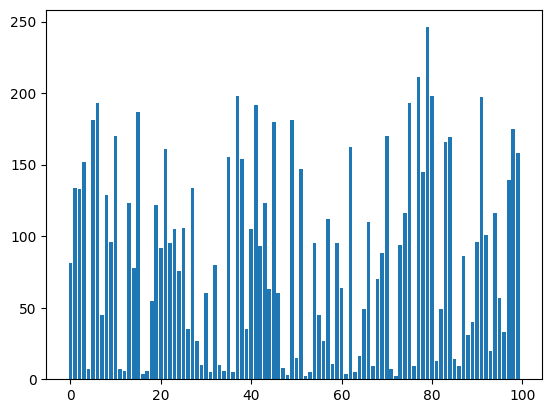

In [11]:
# Simulation
num_wins = 0
num_games_played = 0
num_games_lost_due_to_multiple_guesses = 0
moves_list = []

for _ in tqdm(range(100), ncols=90):
    board = Minesweeper(16, 30, 99)
    moves = 0
    while board.game_running:
        guess, guesses, probmatrix, bombs = make_guess(board)
        board.reveal(guess[0], guess[1])
        moves += 1
    if board.game_won():
        num_wins += 1
    num_games_played += 1
    if not board.game_won():
        num_guesses = guesses.shape[0]
        if num_guesses > 1:
            num_games_lost_due_to_multiple_guesses += 1
    moves_list.append(moves)

print(f"Games Played: {num_games_played}\tWins: {num_wins}")
print(f"Average Number of Moves: {np.mean(moves_list)}")
print(num_games_lost_due_to_multiple_guesses)
plt.bar(range(len(moves_list)), moves_list)